In [73]:
import src.dataPipeline as dataPipeline
import importlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
# Evaluating the model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error,r2_score ,make_scorer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

importlib.reload(dataPipeline)


<module 'src.dataPipeline' from 'C:\\Users\\wartm\\Documents\\FHNW\\immo_challenge\\src\\dataPipeline.py'>

In [3]:
def calculate_metrics(X_train, y_test, y_pred):
    n = len(y_test)  # Number of observations
    k = X_train.shape[1]  # Number of predictors
    r2 = round(r2_score(y_test, y_pred), 4)
    R2_adjusted = round(1 - (1 - r2) * (n - 1) / (n - k - 1), 4)
    mape = round(mean_absolute_percentage_error(y_test, y_pred) * 100, 4)
    return r2, R2_adjusted, mape

In [4]:
def manual_cv_score(X, y, cv, model):
    fold_train_mapes = []
    fold_test_mapes = []

    # Manual CV loop
    for train_idx, test_idx in cv.split(X):
        # Split the data for this fold
        X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
        y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

        # Fit the model
        model.fit(X_tr, y_tr)

        # Predict on training fold
        y_tr_pred = model.predict(X_tr)
        fold_train_mapes.append(mean_absolute_percentage_error(y_tr, y_tr_pred))

        # Predict on test fold
        y_te_pred = model.predict(X_te)
        fold_test_mapes.append(mean_absolute_percentage_error(y_te, y_te_pred))

    # Calculate mean & std for train/test MAPE across folds
    train_mape_mean = np.mean(fold_train_mapes) * 100
    train_mape_std  = np.std(fold_train_mapes)  * 100

    test_mape_mean  = np.mean(fold_test_mapes)  * 100
    test_mape_std   = np.std(fold_test_mapes)   * 100

    return train_mape_mean, train_mape_std, test_mape_mean, test_mape_std

In [5]:
dp = dataPipeline.DataPipeline()
df = dp.runPipeline(
    filePath="../data/immo_data_202208_v2.csv",
    imputer=None,
    normalizeAndStandardize= False,
    basic_house_imputer = False,
    get_dummies = False
)

C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:44: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,49,50,107,110,114,115,116,119,120,121,124,125,126,128,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)
C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:71: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ]].bfill(axis=1)['Space extracted']
C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:76: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in 

In [6]:
#show all columns
pd.set_option('display.max_columns', None)

In [7]:
#drop column Availability
df = df.drop(columns=["Availability"])

In [8]:
df.head()

,Floor,detail_responsive#surface_usable,Floor_space_merged,ForestDensityL,ForestDensityM,ForestDensityS,NoisePollutionRailwayL,NoisePollutionRailwayM,NoisePollutionRailwayS,NoisePollutionRoadL,NoisePollutionRoadM,NoisePollutionRoadS,PopulationDensityL,PopulationDensityM,PopulationDensityS,RiversAndLakesL,RiversAndLakesM,RiversAndLakesS,WorkplaceDensityL,WorkplaceDensityM,WorkplaceDensityS,distanceToTrainStation,gde_area_agriculture_percentage,gde_area_forest_percentage,gde_area_nonproductive_percentage,gde_area_settlement_percentage,gde_average_house_hold,gde_empty_apartments,gde_foreigners_percentage,gde_new_homes_per_1000,gde_politics_bdp,gde_politics_cvp,gde_politics_evp,gde_politics_fdp,gde_politics_glp,gde_politics_gps,gde_politics_pda,gde_politics_rights,gde_politics_sp,gde_politics_svp,gde_pop_per_km2,gde_population,gde_private_apartments,gde_social_help_quota,gde_tax,gde_workers_sector1,gde_workers_sector2,gde_workers_sector3,gde_workers_total,price_cleaned,Space extracted,type_unified,Plot_area_unified,No. of rooms:,Last refurbishment:,Year built:,Number of floors:,region_group
0,4.0,NaN,NaN,0.511176,0.286451,0.090908,0.0,0.0,0.0,0.058298,0.067048,0.103850,0.092914,0.209530,0.366674,0.082170,0.001811,0.011871,0.030169,0.052120,0.098951,3.038467,30.676329,51.449275,4.589372,13.285024,2.23,1.994681,9.255663,4.739336,5.873715,4.579662,3.359031,18.355360,6.057269,7.066814,NaN,0.220264,20.392805,30.809471,376.829268,1545.0,686.0,2.234259,5.89,14.0,9.0,308.0,331.0,1150000.0,100.0,penthouse,NaN,5.0,NaN,NaN,NaN,46.0
1,NaN,NaN,242.0,0.511176,0.286451,0.090908,0.0,0.0,0.0,0.058298,0.067048,0.103850,0.092914,0.209530,0.366674,0.082170,0.001811,0.011871,0.030169,0.052120,0.098951,3.038467,30.676329,51.449275,4.589372,13.285024,2.23,1.994681,9.255663,4.739336,5.873715,4.579662,3.359031,18.355360,6.057269,7.066814,NaN,0.220264,20.392805,30.809471,376.829268,1545.0,686.0,2.234259,5.89,14.0,9.0,308.0,331.0,1420000.0,156.0,terrace-house,222.0,5.0,NaN,NaN,NaN,46.0
2,2.0,NaN,NaN,0.163362,0.095877,0.001911,0.0,0.0,0.0,0.334957,0.381257,0.297575,0.325887,0.393783,0.635194,0.154274,0.188229,0.000000,0.172646,0.163850,0.165830,0.909587,11.354420,32.197891,7.137064,49.310624,2.01,2.023799,21.358623,3.814582,3.633134,5.324421,3.782202,18.089552,7.899807,8.851305,NaN,0.735032,26.515854,22.662290,1704.700162,21036.0,10149.0,3.549010,6.05,37.0,3092.0,30364.0,33493.0,720000.0,93.0,penthouse,NaN,5.0,NaN,NaN,NaN,46.0
3,NaN,NaN,257.0,0.511176,0.286451,0.090908,0.0,0.0,0.0,0.058298,0.067048,0.103850,0.092914,0.209530,0.366674,0.082170,0.001811,0.011871,0.030169,0.052120,0.098951,3.038467,30.676329,51.449275,4.589372,13.285024,2.23,1.994681,9.255663,4.739336,5.873715,4.579662,3.359031,18.355360,6.057269,7.066814,NaN,0.220264,20.392805,30.809471,376.829268,1545.0,686.0,2.234259,5.89,14.0,9.0,308.0,331.0,1430000.0,154.0,detached-house,370.0,5.0,NaN,NaN,NaN,46.0
4,0.0,NaN,NaN,0.333865,0.279276,0.145835,0.0,0.0,0.0,0.133498,0.132933,0.235917,0.190986,0.136984,0.204549,0.109586,0.141473,0.091805,0.046950,0.038008,0.055509,1.460245,33.137090,49.705635,1.177460,15.979815,2.28,0.691563,15.901990,1.160862,5.217740,5.728026,5.006679,19.158429,6.502805,7.477959,NaN,0.892332,20.459524,27.590168,511.008403,6081.0,2638.0,1.708126,6.30,65.0,349.0,941.0,1355.0,995000.0,142.0,flat,NaN,5.0,NaN,NaN,NaN,46.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20786 entries, 0 to 22480
Data columns (total 58 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Floor                              9609 non-null   float64
 1   detail_responsive#surface_usable   104 non-null    float64
 2   Floor_space_merged                 2591 non-null   float64
 3   ForestDensityL                     20786 non-null  float64
 4   ForestDensityM                     20786 non-null  float64
 5   ForestDensityS                     20786 non-null  float64
 6   NoisePollutionRailwayL             20786 non-null  float64
 7   NoisePollutionRailwayM             20786 non-null  float64
 8   NoisePollutionRailwayS             20786 non-null  float64
 9   NoisePollutionRoadL                20786 non-null  float64
 10  NoisePollutionRoadM                20786 non-null  float64
 11  NoisePollutionRoadS                20786 non-null  float64


In [10]:
df["type_unified"] = df["type_unified"].astype('category')

In [11]:
df.head()

,Floor,detail_responsive#surface_usable,Floor_space_merged,ForestDensityL,ForestDensityM,ForestDensityS,NoisePollutionRailwayL,NoisePollutionRailwayM,NoisePollutionRailwayS,NoisePollutionRoadL,NoisePollutionRoadM,NoisePollutionRoadS,PopulationDensityL,PopulationDensityM,PopulationDensityS,RiversAndLakesL,RiversAndLakesM,RiversAndLakesS,WorkplaceDensityL,WorkplaceDensityM,WorkplaceDensityS,distanceToTrainStation,gde_area_agriculture_percentage,gde_area_forest_percentage,gde_area_nonproductive_percentage,gde_area_settlement_percentage,gde_average_house_hold,gde_empty_apartments,gde_foreigners_percentage,gde_new_homes_per_1000,gde_politics_bdp,gde_politics_cvp,gde_politics_evp,gde_politics_fdp,gde_politics_glp,gde_politics_gps,gde_politics_pda,gde_politics_rights,gde_politics_sp,gde_politics_svp,gde_pop_per_km2,gde_population,gde_private_apartments,gde_social_help_quota,gde_tax,gde_workers_sector1,gde_workers_sector2,gde_workers_sector3,gde_workers_total,price_cleaned,Space extracted,type_unified,Plot_area_unified,No. of rooms:,Last refurbishment:,Year built:,Number of floors:,region_group
0,4.0,NaN,NaN,0.511176,0.286451,0.090908,0.0,0.0,0.0,0.058298,0.067048,0.103850,0.092914,0.209530,0.366674,0.082170,0.001811,0.011871,0.030169,0.052120,0.098951,3.038467,30.676329,51.449275,4.589372,13.285024,2.23,1.994681,9.255663,4.739336,5.873715,4.579662,3.359031,18.355360,6.057269,7.066814,NaN,0.220264,20.392805,30.809471,376.829268,1545.0,686.0,2.234259,5.89,14.0,9.0,308.0,331.0,1150000.0,100.0,penthouse,NaN,5.0,NaN,NaN,NaN,46.0
1,NaN,NaN,242.0,0.511176,0.286451,0.090908,0.0,0.0,0.0,0.058298,0.067048,0.103850,0.092914,0.209530,0.366674,0.082170,0.001811,0.011871,0.030169,0.052120,0.098951,3.038467,30.676329,51.449275,4.589372,13.285024,2.23,1.994681,9.255663,4.739336,5.873715,4.579662,3.359031,18.355360,6.057269,7.066814,NaN,0.220264,20.392805,30.809471,376.829268,1545.0,686.0,2.234259,5.89,14.0,9.0,308.0,331.0,1420000.0,156.0,terrace-house,222.0,5.0,NaN,NaN,NaN,46.0
2,2.0,NaN,NaN,0.163362,0.095877,0.001911,0.0,0.0,0.0,0.334957,0.381257,0.297575,0.325887,0.393783,0.635194,0.154274,0.188229,0.000000,0.172646,0.163850,0.165830,0.909587,11.354420,32.197891,7.137064,49.310624,2.01,2.023799,21.358623,3.814582,3.633134,5.324421,3.782202,18.089552,7.899807,8.851305,NaN,0.735032,26.515854,22.662290,1704.700162,21036.0,10149.0,3.549010,6.05,37.0,3092.0,30364.0,33493.0,720000.0,93.0,penthouse,NaN,5.0,NaN,NaN,NaN,46.0
3,NaN,NaN,257.0,0.511176,0.286451,0.090908,0.0,0.0,0.0,0.058298,0.067048,0.103850,0.092914,0.209530,0.366674,0.082170,0.001811,0.011871,0.030169,0.052120,0.098951,3.038467,30.676329,51.449275,4.589372,13.285024,2.23,1.994681,9.255663,4.739336,5.873715,4.579662,3.359031,18.355360,6.057269,7.066814,NaN,0.220264,20.392805,30.809471,376.829268,1545.0,686.0,2.234259,5.89,14.0,9.0,308.0,331.0,1430000.0,154.0,detached-house,370.0,5.0,NaN,NaN,NaN,46.0
4,0.0,NaN,NaN,0.333865,0.279276,0.145835,0.0,0.0,0.0,0.133498,0.132933,0.235917,0.190986,0.136984,0.204549,0.109586,0.141473,0.091805,0.046950,0.038008,0.055509,1.460245,33.137090,49.705635,1.177460,15.979815,2.28,0.691563,15.901990,1.160862,5.217740,5.728026,5.006679,19.158429,6.502805,7.477959,NaN,0.892332,20.459524,27.590168,511.008403,6081.0,2638.0,1.708126,6.30,65.0,349.0,941.0,1355.0,995000.0,142.0,flat,NaN,5.0,NaN,NaN,NaN,46.0


In [12]:
cat_col = ["type_unified"] + [f"region_group_{i}" for i in range(50)]

house_type = ["type_unified"]
num_col = [col for col in df.columns if col not in cat_col + ["price_cleaned"]]

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_col),
        ('cat', categorical_transformer, house_type)
    ]
)

# Random Forest baseline model

In [13]:
rf_baseline = RandomForestRegressor(
    n_estimators=100,
    criterion='squared_error',
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    min_weight_fraction_leaf=0.0,
    max_features=1.0,
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    bootstrap=True,
    oob_score=False,
    n_jobs=None,
    random_state=42,
    verbose=0,
    warm_start=False,
    ccp_alpha=0.0,
    max_samples=None,
    monotonic_cst=None
)

In [14]:
# Create and combine preprocessing and modeling in a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_baseline)
])

# Separate target and features
X = df.drop(columns=["price_cleaned"])
y = df["price_cleaned"]
y = np.log(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer()),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Floor',
                                                   'detail_responsive#surface_usable',
                                                   'Floor_space_merged',
                                                   'ForestDensityL',
                                                   'ForestDensityM',
                                                   'ForestDensityS',
                                                   'NoisePollutionRailwayL',
                                                   'NoisePollutionRailwayM',
                                                   'NoisePollutionRailwayS',
                                                   'NoisePollutionRo...
                                                   'gde_area_forest_percentage',
                                                   'gde_area_nonproductive_percentage',
                                                   'gde_area_settlement_percentage',
                                                   'gde_average_house_hold',
                                                   'gde_empty_apartments',
                                                   'gde_foreigners_percentage',
                                                   'gde_new_homes_per_1000', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['type_unified'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [15]:
#caluclate mape on train data
y_pred = pipeline.predict(X_train)
r2, R2_adjusted, mape = calculate_metrics(X_train, np.exp(y_train) , np.exp(y_pred))
print(f"R2 {r2},Adjusted R^2:{R2_adjusted}, MAPE:{mape}%")

R2 0.9426,Adjusted R^2:0.9424, MAPE:8.3038%


In [16]:
#caluclate mape on test data
y_pred = pipeline.predict(X_test)
r2, R2_adjusted, mape=calculate_metrics(X_train, np.exp(y_test), np.exp(y_pred))
print(f"R2 {r2},Adjusted R^2:{R2_adjusted}, MAPE:{mape}%")

R2 0.7085,Adjusted R^2:0.7044, MAPE:24.931%


# Hyperparameter tuning: Estimators

In [17]:
# Suppose we have these
estimators = [10, 20, 50, 70, 100, 200]
cv = KFold(n_splits=5, shuffle=True, random_state=42)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed)


train_mape_scores_mean = []
train_mape_scores_std = []
test_mape_scores_mean = []
test_mape_scores_std = []

In [18]:
for estimator in tqdm(estimators):
    rf_estimator = RandomForestRegressor(
        n_estimators=estimator,
        criterion='squared_error',
        random_state=42,
        n_jobs=-1
    )
    pipeline = Pipeline(steps=[('model', rf_estimator)])

    # For storing MAPE per fold
    fold_train_mapes = []
    fold_test_mapes = []

    # Manual CV loop
    for train_idx, test_idx in cv.split(X_train_preprocessed):
        X_tr, X_te = X_train_preprocessed.iloc[train_idx], X_train_preprocessed.iloc[test_idx]
        y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]

        pipeline.fit(X_tr, y_tr)

        # Predict on training fold
        y_tr_pred = pipeline.predict(X_tr)
        fold_train_mapes.append(mean_absolute_percentage_error(np.exp(y_tr), np.exp(y_tr_pred)))

        # Predict on test fold
        y_te_pred = pipeline.predict(X_te)
        fold_test_mapes.append(mean_absolute_percentage_error(np.exp(y_te), np.exp(y_te_pred)))


    # Average across folds
    train_mape_mean = np.mean(fold_train_mapes) * 100
    train_mape_std = np.std(fold_train_mapes) * 100

    test_mape_mean = np.mean(fold_test_mapes) * 100
    test_mape_std = np.std(fold_test_mapes) * 100

    # Store results
    train_mape_scores_mean.append(train_mape_mean)
    train_mape_scores_std.append(train_mape_std)
    test_mape_scores_mean.append(test_mape_mean)
    test_mape_scores_std.append(test_mape_std)

    print(
        f"Estimator: {estimator}, "
        f"Train MAPE: {train_mape_mean:.2f}% (±{train_mape_std:.2f}), "
        f"Test MAPE: {test_mape_mean:.2f}% (±{test_mape_std:.2f})"
    )

 17%|█▋        | 1/6 [00:13<01:09, 13.84s/it]

Estimator: 10, Train MAPE: 9.89% (±0.16), Test MAPE: 27.36% (±2.12)


 33%|███▎      | 2/6 [00:37<01:17, 19.46s/it]

Estimator: 20, Train MAPE: 9.16% (±0.11), Test MAPE: 26.59% (±2.67)


 50%|█████     | 3/6 [01:39<01:56, 38.84s/it]

Estimator: 50, Train MAPE: 8.61% (±0.07), Test MAPE: 25.91% (±2.46)


 67%|██████▋   | 4/6 [03:05<01:55, 57.67s/it]

Estimator: 70, Train MAPE: 8.52% (±0.05), Test MAPE: 25.80% (±2.34)


 83%|████████▎ | 5/6 [05:12<01:22, 82.43s/it]

Estimator: 100, Train MAPE: 8.43% (±0.05), Test MAPE: 25.79% (±2.40)


100%|██████████| 6/6 [09:18<00:00, 93.15s/it] 

Estimator: 200, Train MAPE: 8.35% (±0.05), Test MAPE: 25.66% (±2.36)


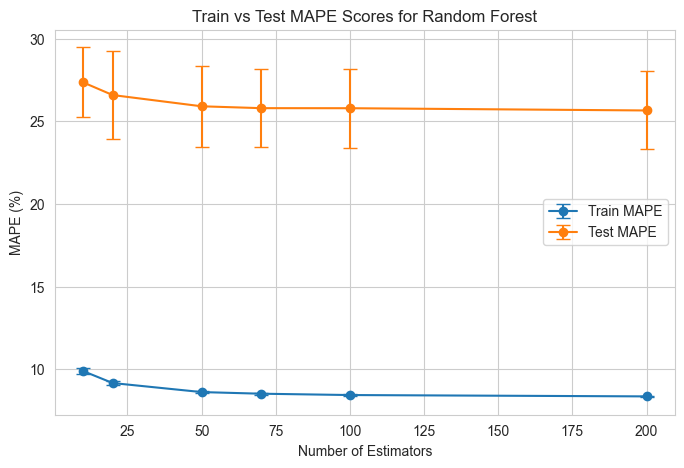

In [19]:
# Plot the MAPE scores
plt.figure(figsize=(8, 5))
plt.errorbar(estimators, train_mape_scores_mean, yerr=train_mape_scores_std, label='Train MAPE', marker='o', capsize=5)
plt.errorbar(estimators, test_mape_scores_mean, yerr=test_mape_scores_std, label='Test MAPE', marker='o', capsize=5)
plt.xlabel('Number of Estimators')
plt.ylabel('MAPE (%)')
plt.title('Train vs Test MAPE Scores for Random Forest')
plt.legend()
plt.grid(True)
plt.show()



# Hyperparameter tuning: Max Depth

In [ ]:
# Suppose we have these
depths = [7, 10, 15, 20, 25, 30, 35]
cv = KFold(n_splits=5, shuffle=True, random_state=42)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed)

train_mape_scores_mean = []
train_mape_scores_std = []
test_mape_scores_mean = []
test_mape_scores_std = []
for depth in tqdm(depths):
    rf_estimator = RandomForestRegressor(
        n_estimators=70,
        max_depth=depth,
        criterion='squared_error',
        random_state=42,
        n_jobs=-1
    )
    pipeline = Pipeline(steps=[('model', rf_estimator)])

    # For storing MAPE per fold
    fold_train_mapes = []
    fold_test_mapes = []

    # Manual CV loop
    for train_idx, test_idx in cv.split(X_train_preprocessed):
        X_tr, X_te = X_train_preprocessed.iloc[train_idx], X_train_preprocessed.iloc[test_idx]
        y_tr, y_te = y_train.iloc[train_idx], y_train.iloc[test_idx]

        pipeline.fit(X_tr, y_tr)

        # Predict on training fold
        y_tr_pred = pipeline.predict(X_tr)
        fold_train_mapes.append(mean_absolute_percentage_error(np.exp(y_tr), np.exp(y_tr_pred)))

        # Predict on test fold
        y_te_pred = pipeline.predict(X_te)
        fold_test_mapes.append(mean_absolute_percentage_error(np.exp(y_te), np.exp(y_te_pred)))

    # Average across folds
    train_mape_mean = np.mean(fold_train_mapes) * 100
    train_mape_std = np.std(fold_train_mapes) * 100

    test_mape_mean = np.mean(fold_test_mapes) * 100
    test_mape_std = np.std(fold_test_mapes) * 100

    # Store results
    train_mape_scores_mean.append(train_mape_mean)
    train_mape_scores_std.append(train_mape_std)
    test_mape_scores_mean.append(test_mape_mean)
    test_mape_scores_std.append(test_mape_std)

    print(
        f"Estimator: {depth}, "
        f"Train MAPE: {train_mape_mean:.2f}% (±{train_mape_std:.2f}), "
        f"Test MAPE: {test_mape_mean:.2f}% (±{test_mape_std:.2f})"
    )

In [ ]:
# Plot the MAPE scores
plt.figure(figsize=(8, 5))
plt.errorbar(depths, train_mape_scores_mean, yerr=train_mape_scores_std, label='Train MAPE', marker='o', capsize=5)
plt.errorbar(depths, test_mape_scores_mean, yerr=test_mape_scores_std, label='Test MAPE', marker='o', capsize=5)
plt.xlabel('Max Depth')
plt.ylabel('MAPE (%)')
plt.title('Train vs Test MAPE Scores for Random Forest')
plt.legend()
plt.grid(True)
plt.show()

# Hyperparameter tuning: Min Samples Split

In [ ]:
min_samples_splits  = [2, 3, 4, 5]
cv = KFold(n_splits=5, shuffle=True, random_state=42)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed)

# Prepare lists to store results
train_mape_scores_mean = []
train_mape_scores_std = []
test_mape_scores_mean = []
test_mape_scores_std = []

# Loop over different depths
for split in tqdm(min_samples_splits):
    # Define your estimator with the current max_depth
    rf_estimator = RandomForestRegressor(
        n_estimators=70,
        max_depth=25,
        min_samples_split=split,
        criterion='squared_error',
        random_state=42,
        n_jobs=-1
    )

    # Build a Pipeline (you can add more steps if needed)
    pipeline = Pipeline(steps=[('model', rf_estimator)])

    # Call the function to perform manual CV and get MAPE metrics
    train_mape_mean, train_mape_std, test_mape_mean, test_mape_std = manual_cv_score(
        X=X_train_preprocessed,
        y=y_train,
        cv=cv,
        model=pipeline
    )

    # Store results
    train_mape_scores_mean.append(train_mape_mean)
    train_mape_scores_std.append(train_mape_std)
    test_mape_scores_mean.append(test_mape_mean)
    test_mape_scores_std.append(test_mape_std)

    # Print progress
    print(
        f"Max split: {split}, "
        f"Train MAPE: {train_mape_mean:.2f}% (±{train_mape_std:.2f}), "
        f"Test MAPE: {test_mape_mean:.2f}% (±{test_mape_std:.2f})"
    )

In [ ]:
# Plot the MAPE scores
plt.figure(figsize=(8, 5))
plt.errorbar(min_samples_splits, train_mape_scores_mean, yerr=train_mape_scores_std, label='Train MAPE', marker='o', capsize=5)
plt.errorbar(min_samples_splits, test_mape_scores_mean, yerr=test_mape_scores_std, label='Test MAPE', marker='o', capsize=5)
plt.xlabel('Max Depth')
plt.ylabel('MAPE (%)')
plt.title('Train vs Test MAPE Scores for Random Forest')
plt.legend()
plt.grid(True)
plt.show()

# Hyperparameter tuning: Max Features


In [ ]:
max_features = [1.0, 0.5, 0.3, 'sqrt', 'log2']

cv = KFold(n_splits=5, shuffle=True, random_state=42)

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed)

# Prepare lists to store results
train_mape_scores_mean = []
train_mape_scores_std = []
test_mape_scores_mean = []
test_mape_scores_std = []

# Loop over different depths
for feature in tqdm(max_features):
    # Define your estimator with the current max_depth
    rf_estimator = RandomForestRegressor(
        n_estimators=70,
        max_depth=25,
        min_samples_split=2,
        max_features=feature,
        criterion='squared_error',
        random_state=42,
        n_jobs=-1
    )

    # Build a Pipeline (you can add more steps if needed)
    pipeline = Pipeline(steps=[('model', rf_estimator)])

    # Call the function to perform manual CV and get MAPE metrics
    train_mape_mean, train_mape_std, test_mape_mean, test_mape_std = manual_cv_score(
        X=X_train_preprocessed,
        y=y_train,
        cv=cv,
        model=pipeline
    )

    # Store results
    train_mape_scores_mean.append(train_mape_mean)
    train_mape_scores_std.append(train_mape_std)
    test_mape_scores_mean.append(test_mape_mean)
    test_mape_scores_std.append(test_mape_std)

    # Print progress
    print(
        f"Max features: {feature}, "
        f"Train MAPE: {train_mape_mean:.2f}% (±{train_mape_std:.2f}), "
        f"Test MAPE: {test_mape_mean:.2f}% (±{test_mape_std:.2f})"
    )


In [ ]:
# Plot the MAPE scores
plt.figure(figsize=(8, 5))
plt.errorbar(feature, train_mape_scores_mean, yerr=train_mape_scores_std, label='Train MAPE', marker='o', capsize=5)
plt.errorbar(feature, test_mape_scores_mean, yerr=test_mape_scores_std, label='Test MAPE', marker='o', capsize=5)
plt.xlabel('Max Features')
plt.ylabel('MAPE (%)')
plt.title('Train vs Test MAPE Scores for Random Forest')
plt.legend()
plt.grid(True)
plt.show()


# Hyperparameter tuning: Min Samples Leaf

In [ ]:
min_samples_leafs = [1, 2, 3, 4, 5]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare lists to store results
train_mape_scores_mean = []
train_mape_scores_std = []
test_mape_scores_mean = []
test_mape_scores_std = []

# Loop over different depths
for leafs in tqdm(min_samples_leafs):
    # Define your estimator with the current max_depth
    rf_estimator = RandomForestRegressor(
        n_estimators=70,
        max_depth=25,
        min_samples_split=2,
        min_samples_leaf=leafs,
        max_features=1,
        criterion='squared_error',
        random_state=42,
        n_jobs=-1
    )

    # Build a Pipeline (you can add more steps if needed)
    pipeline = Pipeline(steps=[('model', rf_estimator)])

    # Call the function to perform manual CV and get MAPE metrics
    train_mape_mean, train_mape_std, test_mape_mean, test_mape_std = manual_cv_score(
        X=X_train_preprocessed,
        y=y_train,
        cv=cv,
        model=pipeline
    )

    # Store results
    train_mape_scores_mean.append(train_mape_mean)
    train_mape_scores_std.append(train_mape_std)
    test_mape_scores_mean.append(test_mape_mean)
    test_mape_scores_std.append(test_mape_std)

    # Print progress
    print(
        f"Max leafs: {leafs}, "
        f"Train MAPE: {train_mape_mean:.2f}% (±{train_mape_std:.2f}), "
        f"Test MAPE: {test_mape_mean:.2f}% (±{test_mape_std:.2f})"
    )

In [ ]:
# Plot the MAPE scores
plt.figure(figsize=(8, 5))
plt.errorbar(leafs, train_mape_scores_mean, yerr=train_mape_scores_std, label='Train MAPE', marker='o', capsize=5)
plt.errorbar(leafs, test_mape_scores_mean, yerr=test_mape_scores_std, label='Test MAPE', marker='o', capsize=5)
plt.xlabel('Max Features')
plt.ylabel('MAPE (%)')
plt.title('Train vs Test MAPE Scores for Random Forest')
plt.legend()
plt.grid(True)
plt.show()


# Hyperparameter tuning: max_leaf_nodes

In [ ]:
max_leaf_nodes = [300, None]

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare lists to store results
train_mape_scores_mean = []
train_mape_scores_std = []
test_mape_scores_mean = []
test_mape_scores_std = []

# Loop over different depths
for node in tqdm(max_leaf_nodes):
    # Define your estimator with the current max_depth
    rf_estimator = RandomForestRegressor(
        n_estimators=70,
        max_depth=25,
        min_samples_split=2,
        max_leaf_nodes=node,
        min_samples_leaf=1,
        max_features=1,
        criterion='squared_error',
        random_state=42,
        n_jobs=-1
    )

    # Build a Pipeline (you can add more steps if needed)
    pipeline = Pipeline(steps=[('model', rf_estimator)])

    # Call the function to perform manual CV and get MAPE metrics
    train_mape_mean, train_mape_std, test_mape_mean, test_mape_std = manual_cv_score(
        X=X_train_preprocessed,
        y=y_train,
        cv=cv,
        model=pipeline
    )

    # Store results
    train_mape_scores_mean.append(train_mape_mean)
    train_mape_scores_std.append(train_mape_std)
    test_mape_scores_mean.append(test_mape_mean)
    test_mape_scores_std.append(test_mape_std)

    # Print progress
    print(
        f"Max leafs node: {node}, "
        f"Train MAPE: {train_mape_mean:.2f}% (±{train_mape_std:.2f}), "
        f"Test MAPE: {test_mape_mean:.2f}% (±{test_mape_std:.2f})"
    )


# Hyperparameter tuning: ccp_alpha

In [ ]:
ccp_alphas = [0.0, 0.1, 0.01, 0.001]

X_train_preprocessed = preprocessor.fit_transform(X_train)
X_train_preprocessed = pd.DataFrame(X_train_preprocessed)

cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Prepare lists to store results
train_mape_scores_mean = []
train_mape_scores_std = []
test_mape_scores_mean = []
test_mape_scores_std = []

# Loop over different depths
for alpha in tqdm(ccp_alphas):
    # Define your estimator with the current max_depth
    rf_estimator = RandomForestRegressor(
        n_estimators=70,
        max_depth=25,
        min_samples_split=2,
        max_leaf_nodes=None,
        min_samples_leaf=1,
        max_features=1,
        criterion='squared_error',
        random_state=42,
        n_jobs=-1,
        ccp_alpha=alpha
    )

    # Build a Pipeline (you can add more steps if needed)
    pipeline = Pipeline(steps=[('model', rf_estimator)])

    # Call the function to perform manual CV and get MAPE metrics
    train_mape_mean, train_mape_std, test_mape_mean, test_mape_std = manual_cv_score(
        X=X_train_preprocessed,
        y=y_train,
        cv=cv,
        model=pipeline
    )

    # Store results
    train_mape_scores_mean.append(train_mape_mean)
    train_mape_scores_std.append(train_mape_std)
    test_mape_scores_mean.append(test_mape_mean)
    test_mape_scores_std.append(test_mape_std)

    # Print progress
    print(
        f"ccp_alpha: {alpha}, "
        f"Train MAPE: {train_mape_mean:.2f}% (±{train_mape_std:.2f}), "
        f"Test MAPE: {test_mape_mean:.2f}% (±{test_mape_std:.2f})"
    )

# Hyperparameter tuning: Optuna

In [74]:
import optuna
from sklearn.impute import SimpleImputer

In [75]:
dp = dataPipeline.DataPipeline()
df = dp.runPipeline(
    filePath="../data/immo_data_202208_v2.csv",
    imputer=None,
    normalizeAndStandardize=False,
    basic_house_imputer=True,
    get_dummies=False
)
df.head()

C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:44: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,47,49,50,107,110,114,115,116,119,120,121,124,125,126,128,131,132) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)
C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:71: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ]].bfill(axis=1)['Space extracted']
C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:76: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in 

,Availability,Floor,detail_responsive#surface_usable,Floor_space_merged,ForestDensityL,ForestDensityM,ForestDensityS,NoisePollutionRailwayL,NoisePollutionRailwayM,NoisePollutionRailwayS,NoisePollutionRoadL,NoisePollutionRoadM,NoisePollutionRoadS,PopulationDensityL,PopulationDensityM,PopulationDensityS,RiversAndLakesL,RiversAndLakesM,RiversAndLakesS,WorkplaceDensityL,WorkplaceDensityM,WorkplaceDensityS,distanceToTrainStation,gde_area_agriculture_percentage,gde_area_forest_percentage,gde_area_nonproductive_percentage,gde_area_settlement_percentage,gde_average_house_hold,gde_empty_apartments,gde_foreigners_percentage,gde_new_homes_per_1000,gde_politics_bdp,gde_politics_cvp,gde_politics_evp,gde_politics_fdp,gde_politics_glp,gde_politics_gps,gde_politics_pda,gde_politics_rights,gde_politics_sp,gde_politics_svp,gde_pop_per_km2,gde_population,gde_private_apartments,gde_social_help_quota,gde_tax,gde_workers_sector1,gde_workers_sector2,gde_workers_sector3,gde_workers_total,price_cleaned,Space extracted,type_unified,Plot_area_unified,No. of rooms:,Last refurbishment:,Year built:,Number of floors:,region_group
0,On request,4.0,0.0,NaN,0.511176,0.286451,0.090908,0.0,0.0,0.0,0.058298,0.067048,0.103850,0.092914,0.209530,0.366674,0.082170,0.001811,0.011871,0.030169,0.052120,0.098951,3.038467,30.676329,51.449275,4.589372,13.285024,2.23,1.994681,9.255663,4.739336,5.873715,4.579662,3.359031,18.355360,6.057269,7.066814,NaN,0.220264,20.392805,30.809471,376.829268,1545.0,686.0,2.234259,5.89,14.0,9.0,308.0,331.0,1150000.0,100.0,penthouse,0.0,5.0,NaN,NaN,1.0,23.0
1,On request,0.0,0.0,242.0,0.511176,0.286451,0.090908,0.0,0.0,0.0,0.058298,0.067048,0.103850,0.092914,0.209530,0.366674,0.082170,0.001811,0.011871,0.030169,0.052120,0.098951,3.038467,30.676329,51.449275,4.589372,13.285024,2.23,1.994681,9.255663,4.739336,5.873715,4.579662,3.359031,18.355360,6.057269,7.066814,NaN,0.220264,20.392805,30.809471,376.829268,1545.0,686.0,2.234259,5.89,14.0,9.0,308.0,331.0,1420000.0,156.0,terrace-house,222.0,5.0,NaN,NaN,1.0,23.0
2,Immediately,2.0,0.0,NaN,0.163362,0.095877,0.001911,0.0,0.0,0.0,0.334957,0.381257,0.297575,0.325887,0.393783,0.635194,0.154274,0.188229,0.000000,0.172646,0.163850,0.165830,0.909587,11.354420,32.197891,7.137064,49.310624,2.01,2.023799,21.358623,3.814582,3.633134,5.324421,3.782202,18.089552,7.899807,8.851305,NaN,0.735032,26.515854,22.662290,1704.700162,21036.0,10149.0,3.549010,6.05,37.0,3092.0,30364.0,33493.0,720000.0,93.0,penthouse,0.0,5.0,NaN,NaN,1.0,23.0
3,On request,0.0,0.0,257.0,0.511176,0.286451,0.090908,0.0,0.0,0.0,0.058298,0.067048,0.103850,0.092914,0.209530,0.366674,0.082170,0.001811,0.011871,0.030169,0.052120,0.098951,3.038467,30.676329,51.449275,4.589372,13.285024,2.23,1.994681,9.255663,4.739336,5.873715,4.579662,3.359031,18.355360,6.057269,7.066814,NaN,0.220264,20.392805,30.809471,376.829268,1545.0,686.0,2.234259,5.89,14.0,9.0,308.0,331.0,1430000.0,154.0,detached-house,370.0,5.0,NaN,NaN,1.0,23.0
4,On request,0.0,0.0,NaN,0.333865,0.279276,0.145835,0.0,0.0,0.0,0.133498,0.132933,0.235917,0.190986,0.136984,0.204549,0.109586,0.141473,0.091805,0.046950,0.038008,0.055509,1.460245,33.137090,49.705635,1.177460,15.979815,2.28,0.691563,15.901990,1.160862,5.217740,5.728026,5.006679,19.158429,6.502805,7.477959,NaN,0.892332,20.459524,27.590168,511.008403,6081.0,2638.0,1.708126,6.30,65.0,349.0,941.0,1355.0,995000.0,142.0,flat,0.0,5.0,NaN,NaN,1.0,23.0


In [79]:
df["region_group"] = df["region_group"].astype("category")
df["type_unified"] = df["type_unified"].astype("category")
df["Availability"] = df["Availability"].astype("category")

In [80]:
#new feature
df['Urbanization_index'] = df['WorkplaceDensityL'] + df['PopulationDensityM'] - df['ForestDensityS']
df['Total_usable_area'] = df['Space extracted'] + df['Plot_area_unified'] + df["detail_responsive#surface_usable"]
df["wohnfläche/anzahl_zimmer"] = df["Space extracted"] / df["No. of rooms:"]


In [81]:
X = df.drop("price_cleaned", axis=1)
y = df["price_cleaned"]

In [82]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Kategorische und numerische Spalten definieren
cat_col = ['region_group', 'type_unified', 'Availability']
numerical_features = [col for col in df.columns if col not in cat_col + ["price_cleaned"]]

# Preprocessing für numerische Daten
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5))  # Fehlwerte auffüllen
#    ('scaler', StandardScaler())  # Standardisieren
])

# Preprocessing für kategorische Daten
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))  # One-Hot-Encoding
])

# ColumnTransformer erstellen
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, cat_col)
    ]
)

# Pipeline nur für das Preprocessing erstellen
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])


X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

In [83]:
y_train_log = np.log(y_train)
y_test_log = np.log(y_test)

In [91]:
def objective(trial):
    # Hyperparameter space to search
    n_estimators = trial.suggest_int("n_estimators", 30, 300)
    max_depth = trial.suggest_int("max_depth", 2,50)
    #min_samples_split = trial.suggest_int("min_samples_split", 2,9)
    #min_samples_leaf = trial.suggest_int("min_samples_leaf", 1,2)
    max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', 0.5, 1.0])
    #max_leaf_node = trial.suggest_int("max_leaf_node", 50, 200)
    #ccp_alpha = trial.suggest_float("ccp_alpha", 0.0, 0.1)
    criterion = trial.suggest_categorical('criterion', ["squared_error", "absolute_error", "friedman_mse", "poisson"])


    # Define the model with trial's parameters
    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        #min_samples_split=min_samples_split,
        #min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        #max_leaf_nodes=max_leaf_node,
        #ccp_alpha=ccp_alpha,
        criterion=criterion,
        n_jobs=-1,
        random_state=42
    )

    # Cross-validation setup
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mape_scores = []

    for fold, (train_index, val_index) in enumerate(kf.split(X_train_transformed)):
        X_train_fold, X_val_fold = X_train_transformed[train_index], X_train_transformed[val_index]
        y_train_fold, y_val_fold = y_train_log.iloc[train_index], y_train_log.iloc[val_index]

        # Fit the model
        model.fit(X_train_fold, y_train_fold)

        # Predict on the validation fold
        y_val_pred_log = model.predict(X_val_fold)

        # Back-transform predictions and ground truth
        y_val_pred = np.exp(y_val_pred_log)
        y_val_actual = np.exp(y_val_fold)

        # Compute MAPE for the fold
        fold_mape = mean_absolute_percentage_error(y_val_actual, y_val_pred)
        mape_scores.append(fold_mape)

        trial.report(sum(mape_scores) / len(mape_scores), step=fold)

        # Check if the trial should be pruned
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    mape_std = np.std(mape_scores)
    trial.set_user_attr("mape_std", mape_std)

    return sum(mape_scores) / len(mape_scores)

In [92]:
# Create and run the Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

# Print the best parameters and score
print("Best Parameters:", study.best_params)
print("Best MAPE:", study.best_value)

[I 2024-12-29 21:26:29,224] A new study created in memory with name: no-name-1c02ecca-d92d-4abd-a71b-8ad745e6443b
[I 2024-12-29 21:28:59,771] Trial 0 finished with value: 0.28792152930898907 and parameters: {'n_estimators': 231, 'max_depth': 11, 'min_samples_split': 8}. Best is trial 0 with value: 0.28792152930898907.
[W 2024-12-29 21:29:13,362] Trial 1 failed with parameters: {'n_estimators': 62, 'max_depth': 16, 'min_samples_split': 3} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\wartm\Documents\FHNW\immo_challenge\venv\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\wartm\AppData\Local\Temp\ipykernel_10776\791866568.py", line 34, in objective
    model.fit(X_train_fold, y_train_fold)
  File "C:\Users\wartm\Documents\FHNW\immo_challenge\venv\Lib\site-packages\sklearn\base.py", line 1473, in wrapper
    return fit_method

KeyboardInterrupt: 

In [133]:
best_params = study.best_params
best_randomforrest = RandomForestRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    #min_samples_split=best_params["min_samples_split"],
    #min_samples_leaf=best_params["min_samples_leaf"],
    max_features=best_params["max_features"],
    #max_leaf_nodes=best_params["max_leaf_node"],
    #ccp_alpha=best_params["ccp_alpha"],
    criterion=best_params["criterion"],
    n_jobs=-1,
    random_state=42
)


In [134]:
best_randomforrest.fit(X_train_transformed, y_train_log)

RandomForestRegressor(criterion='friedman_mse', max_depth=40, max_features=0.5,
                      n_estimators=186, n_jobs=-1, random_state=42)

In [135]:
y_pred = best_randomforrest.predict(X_test_transformed)
test_mape = mean_absolute_percentage_error(np.exp(y_test_log), np.exp(y_pred))
print(f"Test MAPE: {test_mape}")

Test MAPE: 0.24792147926299266


In [147]:
def objective(trial):
    # Hyperparameter space to search
    min_samples_split = trial.suggest_int("min_samples_split", 2, 20)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 10)
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 50, 300)
    ccp_alpha = trial.suggest_float("ccp_alpha", 1e-6, 0.2, log=True)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None, 0.5, 1.0])
    criteria = trial.suggest_categorical("criterion", ["squared_error", "absolute_error", "friedman_mse", "poisson"])


    # Define the model with trial's parameters
    model = RandomForestRegressor(
        n_estimators=156,
        max_depth=26,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        max_features=max_features,
        max_leaf_nodes=max_leaf_nodes,
        ccp_alpha=ccp_alpha,
        criterion=criteria,
        n_jobs=-1,
        random_state=42
    )

    # Cross-validation setup
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    mape_scores = []

    for fold, (train_index, val_index) in enumerate(kf.split(X_train_transformed)):
        X_train_fold, X_val_fold = X_train_transformed[train_index], X_train_transformed[val_index]
        y_train_fold, y_val_fold = y_train_log.iloc[train_index], y_train_log.iloc[val_index]

        # Fit the model
        model.fit(X_train_fold, y_train_fold)

        # Predict on the validation fold
        y_val_pred_log = model.predict(X_val_fold)

        # Back-transform predictions and ground truth
        y_val_pred = np.exp(y_val_pred_log)
        y_val_actual = np.exp(y_val_fold)

        # Compute MAPE for the fold
        fold_mape = mean_absolute_percentage_error(y_val_actual, y_val_pred)
        mape_scores.append(fold_mape)

        trial.report(sum(mape_scores) / len(mape_scores), step=fold)

        # Check if the trial should be pruned
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    mape_std = np.std(mape_scores)
    trial.set_user_attr("mape_std", mape_std)

    return sum(mape_scores) / len(mape_scores)

In [148]:
# Create and run the Optuna study
study = optuna.create_study(direction="minimize",pruner=optuna.pruners.MedianPruner(n_startup_trials=5))
study.optimize(objective, n_trials=25)

# Print the best parameters and score
print("Best Parameters:", study.best_params)
print("Best MAPE:", study.best_value)
print("Standard Deviation of MAPE:", study.best_trial.user_attrs["mape_std"])

[I 2024-12-29 23:41:30,326] A new study created in memory with name: no-name-b2d9b416-edfd-4649-89eb-65c73f3daa78
[I 2024-12-29 23:42:07,579] Trial 0 finished with value: 0.4709316259940256 and parameters: {'min_samples_split': 15, 'min_samples_leaf': 2, 'max_leaf_nodes': 62, 'ccp_alpha': 0.016731322956948118, 'max_features': 0.5, 'criterion': 'squared_error'}. Best is trial 0 with value: 0.4709316259940256.
[I 2024-12-29 23:43:51,342] Trial 1 finished with value: 0.4162364435743383 and parameters: {'min_samples_split': 14, 'min_samples_leaf': 1, 'max_leaf_nodes': 124, 'ccp_alpha': 0.00014591189523155415, 'max_features': None, 'criterion': 'poisson'}. Best is trial 1 with value: 0.4162364435743383.
[I 2024-12-29 23:52:53,050] Trial 2 finished with value: 0.32923937228848166 and parameters: {'min_samples_split': 12, 'min_samples_leaf': 3, 'max_leaf_nodes': 172, 'ccp_alpha': 1.2833800577737437e-06, 'max_features': 'sqrt', 'criterion': 'absolute_error'}. Best is trial 2 with value: 0.3292

KeyboardInterrupt: 

In [132]:
optuna.visualization.plot_param_importances(study)

ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

# Testing the best model on Kaggle dataset

In [136]:
df_kaggle = dp.prepare_kaggle_dataset(
    filePath="../data/test_data-Kaggle-v0.11.csv",
    imputer=None,
    normalizeAndStandardize= False,
    basic_house_imputer = True,
    get_dummies = False
)

C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:44: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,48,49,104,111,112,115,116,117,120,121,122,124,127,128,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  self.data = pd.read_csv(filePath)
C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:71: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  ]].bfill(axis=1)['Space extracted']
C:\Users\wartm\Documents\FHNW\immo_challenge\src\dataPipeline.py:76: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to 

Error in column: Type:


In [137]:
df_kaggle.head()

,Availability,Floor,detail_responsive#surface_usable,Floor_space_merged,ForestDensityL,ForestDensityM,ForestDensityS,NoisePollutionRailwayL,NoisePollutionRailwayM,NoisePollutionRailwayS,NoisePollutionRoadL,NoisePollutionRoadM,NoisePollutionRoadS,PopulationDensityL,PopulationDensityM,PopulationDensityS,RiversAndLakesL,RiversAndLakesM,RiversAndLakesS,WorkplaceDensityL,WorkplaceDensityM,WorkplaceDensityS,distanceToTrainStation,gde_area_agriculture_percentage,gde_area_forest_percentage,gde_area_nonproductive_percentage,gde_area_settlement_percentage,gde_average_house_hold,gde_empty_apartments,gde_foreigners_percentage,gde_new_homes_per_1000,gde_politics_bdp,gde_politics_cvp,gde_politics_evp,gde_politics_fdp,gde_politics_glp,gde_politics_gps,gde_politics_pda,gde_politics_rights,gde_politics_sp,gde_politics_svp,gde_pop_per_km2,gde_population,gde_private_apartments,gde_social_help_quota,gde_tax,gde_workers_sector1,gde_workers_sector2,gde_workers_sector3,gde_workers_total,Space extracted,type_unified,Plot_area_unified,No. of rooms:,Last refurbishment:,Year built:,Number of floors:,Type:,Hall height:,region_group
0,On request,0.0,0.0,NaN,0.164382,0.100030,0.063548,0.003811,0.0,0.0,0.272861,0.220974,0.174300,0.240444,0.293830,0.205251,0.020765,0.034714,0.051031,0.097870,0.103867,0.038822,0.487037,27.803959,44.392083,1.131008,26.672950,2.32,0.793301,32.312312,6.361066,4.330690,5.584311,6.795194,16.278076,5.885845,7.346028,NaN,1.445938,20.528040,30.079776,940.677966,9990.0,4212.0,4.281099,6.35,38.0,1015.0,4188.0,5241.0,220.0,villa,733.0,5.0,NaN,NaN,1.0,NaN,NaN,23
1,On request,0.0,0.0,NaN,0.260855,0.170434,0.083253,0.002623,0.0,0.0,0.227243,0.191344,0.166159,0.171746,0.174532,0.194898,0.017035,0.033235,0.053474,0.064024,0.021157,0.034310,0.691089,27.803959,44.392083,1.131008,26.672950,2.32,0.793301,32.312312,6.361066,4.330690,5.584311,6.795194,16.278076,5.885845,7.346028,NaN,1.445938,20.528040,30.079776,940.677966,9990.0,4212.0,4.281099,6.35,38.0,1015.0,4188.0,5241.0,230.0,detached-house,702.0,5.0,NaN,NaN,1.0,NaN,NaN,23
2,On request,NaN,0.0,NaN,0.434114,0.357984,0.125505,0.000000,0.0,0.0,0.095718,0.152099,0.321114,0.096809,0.153085,0.287587,0.127272,0.067030,0.000000,0.032232,0.076203,0.153552,2.689617,30.676329,51.449275,4.589372,13.285024,2.23,1.994681,9.255663,4.739336,5.873715,4.579662,3.359031,18.355360,6.057269,7.066814,NaN,0.220264,20.392805,30.809471,376.829268,1545.0,686.0,2.234259,5.89,14.0,9.0,308.0,331.0,131.0,stepped-house,0.0,5.0,NaN,NaN,1.0,NaN,NaN,23
3,Immediately,0.0,0.0,140.0,0.148190,0.076610,0.000000,0.005193,0.0,0.0,0.254683,0.259661,0.238364,0.242136,0.317691,0.422582,0.024733,0.030412,0.000000,0.111079,0.207175,0.167494,0.447804,27.803959,44.392083,1.131008,26.672950,2.32,0.793301,32.312312,6.361066,4.330690,5.584311,6.795194,16.278076,5.885845,7.346028,NaN,1.445938,20.528040,30.079776,940.677966,9990.0,4212.0,4.281099,6.35,38.0,1015.0,4188.0,5241.0,140.0,terrace-house,206.0,5.0,NaN,NaN,1.0,NaN,NaN,23
4,On request,0.0,0.0,242.0,0.511176,0.286451,0.090908,0.000000,0.0,0.0,0.058298,0.067048,0.103850,0.092914,0.209530,0.366674,0.082170,0.001811,0.011871,0.030169,0.052120,0.098951,3.038467,30.676329,51.449275,4.589372,13.285024,2.23,1.994681,9.255663,4.739336,5.873715,4.579662,3.359031,18.355360,6.057269,7.066814,NaN,0.220264,20.392805,30.809471,376.829268,1545.0,686.0,2.234259,5.89,14.0,9.0,308.0,331.0,156.0,terrace-house,222.0,5.0,NaN,NaN,1.0,NaN,NaN,23


In [138]:
df_kaggle = df_kaggle.drop(columns=["Type:", "Hall height:","Availability"],axis=1)

In [139]:
cat_col = ["type_unified"] + [f"region_group_{i}" for i in range(50)]

house_type = ["type_unified"]
num_col = [col for col in df_kaggle.columns if col not in cat_col + ["price_cleaned"]]

# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=5))
    #('scaler', StandardScaler())
])

# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessors in a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, num_col),
        ('cat', categorical_transformer, house_type)
    ]
)

In [140]:
rf_best = RandomForestRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    #min_samples_split=best_params["min_samples_split"],
    #min_samples_leaf=best_params["min_samples_leaf"],
    max_features=best_params["max_features"],
    #max_leaf_nodes=best_params["max_leaf_node"],
    #ccp_alpha=best_params["ccp_alpha"],
    criterion=best_params["criterion"],
    n_jobs=-1,
    random_state=42
)

In [141]:
# Create and combine preprocessing and modeling in a pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rf_best)
])

pipeline.fit(X_train, y_train_log)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   KNNImputer())]),
                                                  ['Floor',
                                                   'detail_responsive#surface_usable',
                                                   'Floor_space_merged',
                                                   'ForestDensityL',
                                                   'ForestDensityM',
                                                   'ForestDensityS',
                                                   'NoisePollutionRailwayL',
                                                   'NoisePollutionRailwayM',
                                                   'NoisePollutionRailwayS',
                                                   'NoisePollutionRoadL',
                                                   'NoisePollutionRoadM',
                                                   '...
                                                   'gde_area_settlement_percentage',
                                                   'gde_average_house_hold',
                                                   'gde_empty_apartments',
                                                   'gde_foreigners_percentage',
                                                   'gde_new_homes_per_1000', ...]),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['type_unified'])])),
                ('model',
                 RandomForestRegressor(criterion='friedman_mse', max_depth=40,
                                       max_features=0.5, n_estimators=186,
                                       n_jobs=-1, random_state=42))])

In [142]:
from src.utils.helperFunctions import create_kaggle_results

results = pipeline.predict(df_kaggle)
results = np.exp(results)
create_kaggle_results(results, path_to_kaggledata="../data/test_data-Kaggle-v0.11.csv",csv_name='Randomforrest_tuned')

C:\Users\wartm\Documents\FHNW\immo_challenge\src\utils\helperFunctions.py:13: DtypeWarning: Columns (3,4,5,6,11,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,45,46,48,49,104,111,112,115,116,117,120,121,122,124,127,128,130,131) have mixed types. Specify dtype option on import or set low_memory=False.
  indexes = pd.read_csv(path_to_kaggledata)['Unnamed: 0']


File Randomforrest_tuned_2024-12-29_23-33-20.csv created successfully.
